# Model of planetary motion
by Timothy Novak

In [1]:
# import functions from the modsim.py module
from modsim import *

The following code initializes the state and system objects for the earth sun system.

In [17]:
# Creates a state object which stores the innital state
#distance in meteres velocity in m/s
st8 = State(xpos = 149597900000, 
            ypos = 0, 
            xvel = 0, 
            yvel = 29000)
#Creates a system to hold the simulation parameters
#G = m^3/(kg*s^2) masses are in kg masses are in kg radi are in meteres velocities are in m/s
sys = System(init = st8,
             G = 6.67408*10**(-11), 
             M_earth = 5.972*10**24, 
             M_sun =1.989*10**30, 
             R_earth = 6.3781*10**6, 
             R_sun= 6.95700*10**8, 
             t_end = 365.25*24*60*60*1, 
             sun_pos = Vector(0,0))


The following code describes the functions which constitute the model

In [18]:
#model constituant functions
def get_force(G,M,m,planet_vector, sun_vector):
    """Applies law of universal gravitation and returns the force of gravity as a vector towards the center of the circle in N"""
    #calculates the vector pointing from the planet to the sun
    planet_to_sun_vector = sun_vector-planet_vector
    #takes the direction of the previous vector
    Direction_vector = planet_to_sun_vector/planet_to_sun_vector.mag
    #calculates the acceleration of the planet
    acceleration_mag = (G*M*m)/(planet_vector.mag**2)
    #returns a vector which has the magnitude of the acceleration and a direction towards the star
    return Direction_vector * acceleration_mag

def get_grav_acceleration(G,M,m,planet_vector,sun_vector):
    """Calculates acceleration with F = ma
    F in N
    m in kg
    a in m/s^2"""
    #gets the force and divides by the orbiting body to get the acceleration of the orbing body
    return get_force(G,M,m,planet_vector,sun_vector)/m


def planet_slope_func(st8,t,sys):
    """Describes the change in position and velocity in both the x and y plane between every time step.
    The function takes in a state which describes the old position of the system
    t is the time of the syatem, it is not actually used in calculations however it is a required argument for use with an ODE Solver
    sys is a system object which contains system constants"""
    
    #extracts the values from the state because the ODE solver does not store variables in a state object
    xpos,ypos,xvel,yvel= st8
    #creates a vector which describes the position of the planet
    planet_pos = Vector(xpos,ypos)
    
    #describes a system of differential equations which explain the changes in the system
    #update the velocity in each direction
    dxveldt = get_grav_acceleration(sys.G, sys.M_sun, sys.M_earth, planet_pos,sys.sun_pos).x
    dyveldt = get_grav_acceleration(sys.G, sys.M_sun, sys.M_earth, planet_pos,sys.sun_pos).y
    
    #update the position in each direction
    dxposdt = xvel
    dyposdt = yvel
    
    #returns the change in the state variables
    return dxposdt,dyposdt,dxveldt,dyveldt


The following code runs a simulation of a planet and plots the results

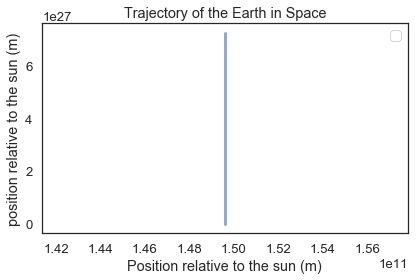

In [19]:
#runs an ODE solver to run a simulation and restricts the ODE solver to taking steps with a maximum size of one day
results,details = run_ode_solver(sys,planet_slope_func, max_step=60*60*24)

#plots the results
plot(results.xpos,results.ypos)

#makes the plot fancy
decorate(title = "Trajectory of the Earth in Space", xlabel = "Position relative to the sun (m)", ylabel = "position relative to the sun (m)")


The following code wraps the code up in a run simulation function so that multiple simulations of a planet-sun system can be run.

In [20]:
def run_planet_simulation (earth_position_x,earth_position_y, earth_velocity_x, earth_velocity_y,earth_mass,num_years):
    """This function runs a simulation of a two body planetary system. 
    This simulation assumes that the sun in the planetary system has the mass of earth's sun and is at a fixed location in space (0,0) for conveianance
    the planet's position velocity and mass are supplied to better inform the simulation.
    The number of years dictates how many years the simulation should be run for.
    The function returns the trajectory of the supplied planet."""
    # creates the state for the simulation
    #distance in meteres velocity in m/s
    st8 = State(xpos = earth_position_x, 
                ypos = earth_position_y, 
                xvel = earth_velocity_x, 
                yvel = earth_velocity_y)
    #Creates a system which holds the parameters of the simulation
    #G = m^3/(kg*s^2) masses are in kg masses are in kg radi are in meteres velocities are in m/s
    sys = System(init = st8,
                 G = 6.67408*10**(-11), 
                 M_earth = earth_mass, 
                 M_sun =1.989*10**30, 
                 R_earth = 6.3781*10**6, 
                 R_sun= 6.95700*10**8, 
                 t_end = 365.25*24*60*60*num_years, 
                 sun_pos = Vector(0,0))
    
    #runs an ODE solver to run the simulation and restricts the ODE solver to taking steps with a maximum size of one day
    results,details = run_ode_solver(sys,planet_slope_func, max_step=60*60*24)
    
    #returns the results of the solver
    return results

This code simulates the effect that firing the railgun has on the earth's velocity. It should be noted that this code will not be accurate for projectiles which do not escape the gravitational pull of earth. This is because the function ignores the projectile once it has been launched so the program will not register such a projectile returning to the earth and recombining with the mass of the earth. 

In [21]:
def fire_cannon(planet_velocity_vector, Mass_earth, Mass_shot, Shot_speed):
    """Runs a function which updates the velocity and mass of a planet assuming that it is accelerated via mass ejection.
    Calculations are based on conservation of momentum.
    Masses are in kilograms
    Speeds are in m/s
    The velocity vector describes the last known velocity of the planet."""
    
    #calculates the magnitude of the new velocity of the planet
    velocity_vector_magnitude = (Mass_earth*planet_velocity_vector.mag + Mass_shot*Shot_speed)/(Mass_earth-Mass_shot) 
    #multiplies the magnitude by a unit vector in the direction of the last known velocity to create a velocity vector in the proper direction
    planet_velocity_vector = (planet_velocity_vector/planet_velocity_vector.mag)*velocity_vector_magnitude
    
    #if the shot_speed is zero then it will not leave the earth and the weight of the earth should not shrink 
    if Shot_speed != 0:
        #updates the mass of the earth to account for the fact that the shot removed mass from the earth
        Mass_earth = Mass_earth - Mass_shot
    
    #retuns the new velocity as a vector and the new mass of the earth
    return planet_velocity_vector, Mass_earth

This code creates a function which encapsulates firing the railgun and the effect which this has on the orbit of the earth.

In [22]:
def run_simulation_after_cannon (Mass_shot, Shot_velocity, number_years_after_shot, orbital_results):
    """This code runs a simulation of the earth firing a projectile of a given mass and velocity.
    This code is intended to be run after another simulation of normal orbital motion which will inform the starting position of the earth before the projectile is fired.
    Masses are in kg
    Velocities are in m/s
    number of years after shot is a number whic dictates how long to run the simulation of the earth's orbital motion after the projectile is fired.
    This function returns a time frame containing the x and y poition and velocity of the earth throughout the simulation"""
    #gets a vector of the velocity of earth based on the results of the original simulation
    orbital_velocity = Vector(get_last_value(orbital_results.xvel),get_last_value(orbital_results.yvel))
    
    #fires the railgun
    post_cannon_velocity, post_cannon_mass = fire_cannon(orbital_velocity,5.972*10**24, Mass_shot, Shot_velocity)
    
    #runs a simulation of the earth and the sun with the earth's updated velocity
    escape_results = run_planet_simulation(get_last_value(orbital_results.xpos),get_last_value(orbital_results.ypos),post_cannon_velocity.x,post_cannon_velocity.y,post_cannon_mass,number_years_after_shot)
    
    #escape_results = run_planet_simulation(get_last_value(orbital_results.xpos),get_last_value(orbital_results.ypos),get_last_value(orbital_results.xvel),get_last_value(orbital_results.yvel),5.972*10**24,number_years_after_shot)
    
    #returns the results
    return escape_results
    
    

The following code runs a simulation

In [23]:
#runs a simulation  of the first year
orbital_results = run_planet_simulation(149597900000,0, 0, 29000,5.972*10**24,1)
#put other code here and looping
#tests firing a shot with half the mass of the earth and the same speed as the earth
shot_results = run_simulation_after_cannon(2.5*10**24, 29000, 1, orbital_results)



The following code plots the results from the simulation and displays it as a plot

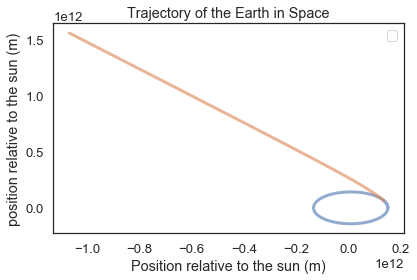

In [24]:
plot(orbital_results.xpos,orbital_results.ypos)
plot(shot_results.xpos,shot_results.ypos)
decorate(title = "Trajectory of the Earth in Space", xlabel = "Position relative to the sun (m)", ylabel = "position relative to the sun (m)")